__Что щас не сделано__
1. Не считаются географические координаты
2. Сборка выходного изображения

__Вопросики__

1. ...


__Варианты улучшения ситуации по результатам консультации 29.10__

1. Малый патч -> большой батч

2. Аугментация тренировочных данных белым шумом. Вышибаем клин клином

3. Больше патч

4. Больше патч -> глубже сеть

5. Dropout оставляем только на линейных

6. Подобрать оптимальный learning rate

__Ситуация на 30.10__

Кажется, что оно учится, потому что matthews_corrcoef для accuracy = 50 % равен 0, а у меня около 0,5. Но, кажется, я неправильно сохранила самую путную модель, но проверить или заново ее обучить я уже не успеваю... Патч был 15, модель была вторая из тех, что представлены, 10 эпох шли долго. Графики лоссов есть, значение мсс тоже, Александр рекомендовал ранее также оценить качество по ROC_AUC и Precision_Recall_AUC, но их я на момент предыдущего обучения еще не успела прикрутить. 

Другое дело, что мсс не особо меняется, хотя менялись патчи и лоссы... Может, стоит поработать надо порогом разделения ответов модели на 0 и 1, сейчас стоит 0.5

Все метрики в функции final_validate (matthews_corrcoef, ROC_AUC, Precision_Recall_AUC)

В общем, возможно, мне нужно еще поиграться

## Подготовка данных

Импорт необходимых библиотек

In [1]:
import numpy as np
from osgeo import gdal
from tqdm import tqdm
from tqdm import trange
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# from sklearn.metrics import plot_roc_curve
# from sklearn.metrics import PrecisionRecallDisplay

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

True

Нам понадобятся для работы некоторые функции, соберем их тут, чтобы потом не мешались

Прежде всего, нам нужен класс для подготовки датасета. Он должен
1. Нарезать на патчи (заданного размера)
2. Определять класс центрального пиксела патча (на основе соответственного патча маски)
3. Вычислять координаты этого пиксела и складывать их куда-то, чтобы потом можно было восстановить изображение
4. Кстати, раз мы режем на патчи после отделения тестового и валидационного куска, надо также подавать значения порогов отделения, чтобы восстанавливать координаты?

In [2]:
class Patcher(Dataset):
    def __init__(self, image, mask, transform, patch_size):
        super().__init__()
              
        self.image = image
        self.mask = mask
        self.transform = transform
        self.patch_size = patch_size
        self.im_h, self.im_w = image.shape[0], image.shape[1]
    
        half_patch = self.patch_size // 2
        coord_list = list()
        for central_x in tqdm(range(half_patch, self.im_w - half_patch)): 
            for central_y in range(half_patch, self.im_h - half_patch):
                if (self.image[central_y - half_patch:central_y + half_patch + 1,
                               central_x - half_patch:central_x + half_patch + 1] != 0).all():
                    coord_list.append([central_y, central_x])
        self.coords = np.array(coord_list)
        self.size = len(self.coords)

    def __getitem__(self, indx):
        central_x = self.coords[indx, 1]
        central_y = self.coords[indx, 0]
        
        half_patch = self.patch_size // 2
        patch = self.image[central_y - half_patch:central_y + half_patch + 1, 
                           central_x - half_patch:central_x + half_patch + 1]
        label = self.mask[central_y][central_x]
        return self.transform(patch), torch.tensor(label), indx # dataset.coords[indx]
    
    def __len__(self):
        return self.size

In [24]:
# функция для валидации
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    mcc = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train, coords = batch
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train) # get predictions
#             loss = criterion(y_pred, y_train) # compute loss
            loss = criterion(y_pred.squeeze(), y_train.to(torch.float32)) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
            y_pred = y_pred.squeeze().cpu()
            y_pred = torch.where(y_pred > 0.5, 1, 0)
            mcc_batch = matthews_corrcoef(y_train.to(torch.float32).cpu(), y_pred)
            mcc.append(mcc_batch)
    return cumloss / len(val_loader), loss_history, np.mean(mcc) # mean loss and history

In [ ]:
# функция для валидации на тесте 
# прикрутить координаты
def final_validate(model, 
                  criterion,
                  test_loader):
    model_cnn.eval()
    cumloss = 0
    labels = []
    outputs = []
    coords = []
    with torch.no_grad():
        for batch in test_loader:
            patch, label, coord = batch
            patch, label = patch.to(device), label.to(device)
            y_pred = model(patch) # get predictions
            loss = criterion(y_pred.squeeze(), label.to(torch.float32)) # compute loss
            cumloss += loss
            y_pred = y_pred.squeeze().cpu()
            y_pred = torch.where(y_pred > 0.5, 1, 0)
            outputs.append(y_pred)
            labels.append(label.to(torch.float32).cpu())
            coords.append(coord)
        
    cumloss = cumloss / len(test_loader)
    print(f"loss={cumloss:.2}")
    print(f"matthews_correlation_coefficient={matthews_corrcoef(labels, outputs):.2}")
    print(f"ROC_AUC={roc_auc_score(labels, outputs):.2}")
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    print(f"Pr-Rec_AUC={auc(recall, precision):.2}")
    
    return outputs, coords

In [7]:
# функция для обучения
def train(model, train_data, test_data, criterion, optimizer, num_epochs = 10):
    loss_hist = []
    accuracy_lst = []
    epochs = trange(num_epochs)
    for epoch in tqdm(epochs):
        ep_loss = 0
        model.train()
        for batch in train_data:
            imgs, labels, coords = batch
            imgs, labels = imgs.to(device), labels.to(device)     
            optimizer.zero_grad()
            outputs = model(imgs)
#             loss = criterion(outputs, labels)
            loss = criterion(outputs.squeeze(), labels.to(torch.float32))
            loss.backward()
            optimizer.step()
            ep_loss += loss.item()
        loss_hist.append(ep_loss / len(train_data))
        
        model.eval() # dropout!
        _, val_loss, mcc = validate(model, criterion, test_data)
        accuracy_lst.append(val_loss[0])
        
        print(f"Epoch={epoch}  loss={loss_hist[epoch]:.4}  val_loss={val_loss[0]:.4}  mcc={mcc:.2}")
    return accuracy_lst, loss_hist

### Загрузка и предобработка

Задаем пути на изображение, для которого будет проводиться классификация, и на маску (label)

In [8]:
raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20191021_.tif"
mask_path = "D:/oni/from_lakm/tiffs_clip/forest_mask.tif"

Открытие изображений, сохранение информации о пространственной привязке для будущего выходного изображения

In [9]:
image = gdal.Open(raster_path, gdal.GA_ReadOnly)
# получаем инфо о пространственной привязке,
# потому что просто картинка на выходе нам не нужна
xoffset, px_w, rot1, yoffset, px_h, rot2 = image.GetGeoTransform() # для пересчета координат пикселов
projection = image.GetProjectionRef()

mask = gdal.Open(mask_path, gdal.GA_ReadOnly)

In [7]:
print(xoffset, px_w, rot1, yoffset, px_h, rot2)
print(projection)

499997.52242239844 10.0 0.0 6951689.007115613 0.0 -10.0
PROJCS["WGS_1984_UTM_Zone_52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


Информация о проекции очень важна для конечного изображения, но очень бессмысленна для определения координат пикселов. Кстати, а почему я решила, что результирующее изображение будет иметь те же координаты? 

In [10]:
print('image rows and cols:', image.RasterYSize, image.RasterXSize)
print('mask rows and cols:', mask.RasterYSize, mask.RasterXSize)
print('image bands:', image.RasterCount)

image rows and cols: 6146 5008
mask rows and cols: 6146 5009
image bands: 2


Наш снимок в пикселах имеет размер 6146 на 5008, а также содержит 2 канала: это две поляризации (в случае с данными с открытого спутника Sentinel-1) VV и VH. 

А у маски другой размер! На один пиксел! За что! Раз мы сохранили инфу о простанственной привязке  для снимка, придется маску чуть изменить. Визуальный анализ показывает, что у маски на одну первую колонку больше. Спрашивается, почему, если я кропала их всех вместе, но ладно

Переводим снимок в матричку

In [10]:
image_array = image.ReadAsArray()
image_array = np.stack(image_array, axis=2) # move bands to end
image = None 

mask_array = mask.ReadAsArray()
mask_array = np.delete(mask_array, 0, 1) # del first column
mask = None

print(image_array.shape)
print(mask_array.shape)

(6146, 5008, 2)
(6146, 5008)


Нужно нормализовать каналы, поскольку известно, что радиолокационные сигналы достаточно низкие (пока из космоса до Земли долетишь, пока обратно...), а сигнал в кросс-поляризации ниже, чем в согласованной (из-за смены поляризации потери идут). Кроме того, из-за спекл-шума будет достаточно много выбросов. Minmax чувствителен к выбросам очень, standard scaler меньше.

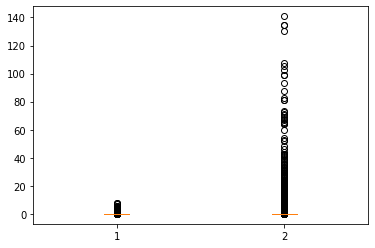

In [96]:
plt.boxplot([image_array[:,:, :1].flatten(), image_array[:,:, 1:].flatten()])
plt.show()

In [11]:
min_b1 = np.min(image_array, axis=(0,1))[0]
min_b2 = np.min(image_array, axis=(0,1))[1]
max_b1 = np.max(image_array, axis=(0,1))[0]
max_b2 = np.max(image_array, axis=(0,1))[1]
mean_b1 = np.mean(image_array, axis=(0,1))[0]
mean_b2 = np.mean(image_array, axis=(0,1))[1]
std_b1 = np.std(image_array, axis=(0,1))[0]
std_b2 = np.std(image_array, axis=(0,1))[1]

print('first channel')
print(f"min={min_b1}  max={max_b1:.2}  mean={mean_b1:.2}  std={std_b1:.2}")
print()
print('second channel')
print(f"min={min_b2}  max={max_b2:.0}  mean={mean_b2:.2}  std={std_b2:.2}")

first channel
min=0.0  max=7.7  mean=0.0083  std=0.0081

second channel
min=0.0  max=1e+02  mean=0.039  std=0.11


In [10]:
# band_1 = (np.squeeze(image_array[:,:, :1], axis=2) - mean_b1) / std_b1
# band_2 = (np.squeeze(image_array[:,:, 1:], axis=2) - mean_b2) / std_b2

In [11]:
# image_norm = np.stack((band_1, band_2), axis=-1)
# image_norm.shape

(6146, 5008, 2)

Посмотрим на долю лесных пикселов среди всех пикселов в маске

In [22]:
print(f'{mask_array[mask_array == 1].size / mask_array.size :.2}')

0.63


Доля 63 %, значит, наблюдается небольшой дисбаланс.

Наверное, стоит визуализировать кусочки изображений

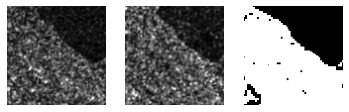

In [10]:
step = 100
figure1 = image_array[1000:1000+step, 600:600+step, :1] # ищем образцово-показательный кусочек
figure2 = image_array[1000:1000+step, 600:600+step, 1:]
figure3 = mask_array[1000:1000+step, 600:600+step]

fig, axis = plt.subplots(1, 3)
# plt.figure(figsize=(6, 6))
axis[0].imshow(figure1, cmap='Greys_r')
axis[1].imshow(figure2, cmap='Greys_r')
axis[2].imshow(figure3, cmap='Greys_r')
for a in axis:
    a.axis('off') 

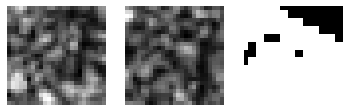

In [12]:
step = 25
figure1 = image_array[1000:1000+step, 600:600+step, :1] # ищем образцово-показательный кусочек
figure2 = image_array[1000:1000+step, 600:600+step, 1:]
figure3 = mask_array[1000:1000+step, 600:600+step]

fig, axis = plt.subplots(1, 3)
# plt.figure(figsize=(6, 6))
axis[0].imshow(figure1, cmap='Greys_r')
axis[1].imshow(figure2, cmap='Greys_r')
axis[2].imshow(figure3, cmap='Greys_r')
for a in axis:
    a.axis('off')  

Судя по всему, лес (1) белый на маске. Можно обратить внимание на то, что на снимке в выбранной поляризации не_лес темнее

Для отработки модели возьмем только часть данных для обучения и валидации

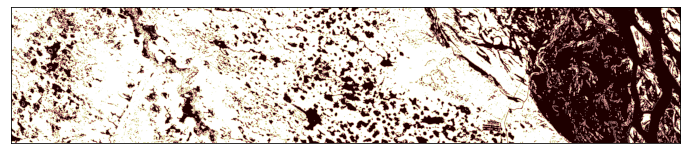

In [35]:
figure1 = mask_array[1500:2500, 100:5000]

plt.figure(figsize=(12, 16))
plt.imshow(figure1, cmap='pink')
plt.grid(False)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()  

In [13]:
# пока мы на этапе "заставить модель работать", возьмем только часть данных
# toy dataset
bound_train = 1500
bound_val = 2500
bound_test = 2700

train_image = image_array[bound_train:bound_val]
train_labels = mask_array[bound_train:bound_val]

val_image = image_array[bound_val:bound_test]
val_labels = mask_array[bound_val:bound_test]

# test_image = image_norm[bound_test:]
# test_labels = mask_array[bound_test:]

Настало время резать на train-test. Отрежем нижние 20 % снимка на тест, преднижние 10 % снимка на валидацию. 

In [9]:
# мне хочется резать по круглым числам, поэтому
# bound_val = int(image_norm.shape[0] * 0.07) * 10 # тут пришлось отбросить единицы при округлении 1/10 от числа
# bound_test = int(image_norm.shape[0] * 0.8) # тут округление вниз кратно 10, мне нравится

# train_image = image_norm[:bound_val]
# train_labels = mask_array[:bound_val]

# val_image = image_norm[bound_val:bound_test]
# val_labels = mask_array[bound_val:bound_test]

# test_image = image_norm[bound_test:]
# test_labels = mask_array[bound_test:]

In [12]:
print(train_image.shape) # 6146 rows total
print(train_labels.shape)
print(val_image.shape)
print(val_labels.shape)
# print(test_image.shape)
# print(test_labels.shape)

(1000, 5008, 2)
(1000, 5008)
(200, 5008, 2)
(200, 5008)


### Подготовка данных к загрузке в модель

Зададим трансформации. Мы хотим добавить шум в тренировочные данные, чтобы модель не учила шум, но шума среди аугментаций в пайторч нет. Придется его добавить самостоятельно

In [14]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [15]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_b1, mean_b2), (std_b1, std_b2)),
    AddGaussianNoise(0., 0.5)])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_b1, mean_b2), (std_b1, std_b2))])

Режем на патчи. Готовим датасет

In [16]:
patch_size = 25
train_dataset = Patcher(train_image, train_labels, train_transform, patch_size)
valid_dataset = Patcher(val_image, val_labels, valid_transform, patch_size)

100%|█████████████████████████████████████████████████████████████████████████████| 4984/4984 [00:05<00:00, 874.95it/s]


In [17]:
print(len(train_dataset))
print(len(valid_dataset))

4816362
869311


In [18]:
batch_size = 512

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False)

Наблюдение: батч = 512 - забивает примерно 40 % видеокарты

### Создание и обучение модели

Собираем модель

In [20]:
class CNN_s1(nn.Module):
    def __init__(self, patch_size: int = 5): # чтобы для разных патчей работала
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=1, padding=1), # shape: [32,patch_size,patch_size]
            nn.MaxPool2d(2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # shape: [64,patch_size//2,patch_size//2] 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # shape: [128,patch_size//2,patch_siz//2e] 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*(patch_size//2)*(patch_size//2), 1000),
            nn.Dropout(),
            nn.ReLU(), 
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

In [ ]:
# такая модель была на обучении 15х15
class CNN_s1(nn.Module):
    def __init__(self, patch_size: int = 5): # чтобы для разных патчей работала
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=1, padding=1), # shape: [32,patch_size,patch_size]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # shape: [64,patch_size,patch_size] 
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # shape: [128,patch_size,patch_size] 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*patch_size*patch_size, 1000),
            nn.Dropout(0.25),
            nn.ReLU(), 
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

Учимся

In [26]:
model_cnn = CNN_s1(patch_size=patch_size).to(device)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
accuracy, loss_hist = train(model_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs = 10)

 10%|███████▉                                                                       | 1/10 [16:47<2:31:11, 1007.91s/it]

Epoch=0  loss=0.3103  val_loss=0.2652  mcc=0.3



 20%|███████████████▊                                                               | 2/10 [34:06<2:16:48, 1026.10s/it]

Epoch=1  loss=0.2969  val_loss=0.2201  mcc=0.23



 30%|███████████████████████▋                                                       | 3/10 [51:09<1:59:32, 1024.71s/it]

Epoch=2  loss=0.2904  val_loss=0.199  mcc=0.36



 40%|██████████████████████████████▊                                              | 4/10 [1:08:23<1:42:48, 1028.14s/it]

Epoch=3  loss=0.2853  val_loss=0.2043  mcc=0.29



 50%|██████████████████████████████████████▌                                      | 5/10 [1:25:11<1:25:04, 1020.99s/it]

Epoch=4  loss=0.2805  val_loss=0.2103  mcc=0.39



 60%|██████████████████████████████████████████████▏                              | 6/10 [1:42:26<1:08:22, 1025.72s/it]

Epoch=5  loss=0.2765  val_loss=0.2033  mcc=0.3


 60%|██████████████████████████████████████████████▏                              | 6/10 [1:54:53<1:16:35, 1148.93s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [ ]:
model_cnn.eval()
mcc = []
with torch.no_grad():
    for patch, label, coords in valid_loader:
        patch, label = patch.to(device), label.to(device)
        outputs = model_cnn(patch)
        outputs = outputs.squeeze().cpu()
        outputs = torch.where(outputs > 0.5, 1, 0)
        mcc_batch = matthews_corrcoef(label.to(torch.float32).cpu(), outputs)
        mcc.append(mcc_batch)
mcc = np.mean(mcc)
print(f"{mcc:0.2}")

Так, падажжите, для случайных ответов в бинарной классификации mcc = 0. Значит, оно все же учится чему-то

15 x 15, mcc = 0.47

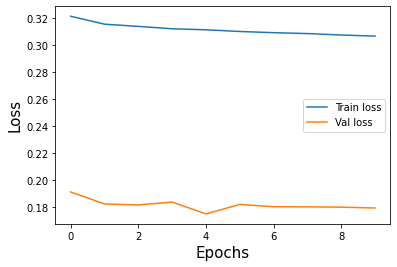

In [22]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

Кажется, что шум на трейне действительно имеет значение, так как лосс для валидации стал заметно ниже

11 x 11, mcc = 0.46

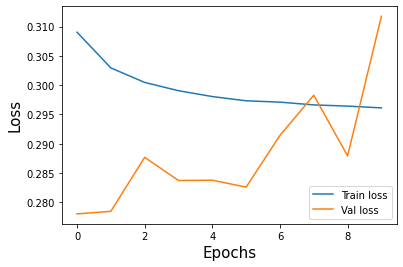

In [24]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

7 x 7, mcc = 0.46

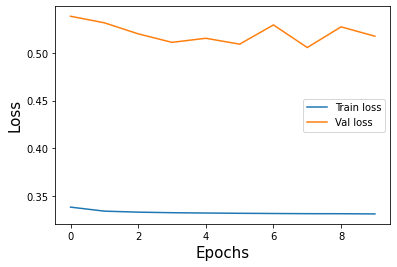

In [26]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

Сохранение модели

In [24]:
# это должна была быть модель 15х15, но я не в курсе, что я сохранила
torch.save(model_cnn, 'D:/oni/from_lakm/models/model_cnn_s1_2910.pkl') # блин, кажется, ее надо было не так сохранять

![cat](http://memesmix.net/media/created/brtpiy.jpg)

Кажется, ее надо было сохранять вот так:

In [ ]:
# save
torch.save(model.state_dict(), PATH)

# load
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

### Оценка качества на тестовых данных

In [ ]:
# test patches
test_dataset = Patcher(test_image, test_labels, valid_transform, patch_size)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)
# validate on test

test_outputs, test_coords = final_validate(model_cnn, 
                                           criterion,
                                           test_loader)

# model_cnn.eval()

# cumloss = 0
# labels = []
# outputs = []
# with torch.no_grad():
#     for batch in test_loader:
#         patch, label, coords = batch
#         patch, label = patch.to(device), label.to(device)
#         y_pred = model(patch) # get predictions
#         loss = criterion(y_pred.squeeze(), label.to(torch.float32)) # compute loss
#         cumloss += loss
#         y_pred = y_pred.squeeze().cpu()
#         y_pred = torch.where(y_pred > 0.5, 1, 0)
#         outputs.append(y_pred)
#         labels.append(label.to(torch.float32).cpu())
        
# cumloss = cumloss / len(test_loader)
# print(f"loss={cumloss:.2}")
# print(f"matthews_correlation_coefficient={matthews_corrcoef(labels, outputs):.2}")
# print(f"ROC_AUC={roc_auc_score(labels, outputs):.2}")
# precision, recall, thresholds = precision_recall_curve(labels, outputs)
# print(f"Pr-Rec_AUC={auc(recall, precision):.2}")

### Формирование выходного изображения

Где-то тут собираем всё в один снимок

In [ ]:
result_image = np.zeros_like(test_labels) # model output

In [ ]:
# про вычисление координат пиксела
# https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()

# # supposing x and y are your pixel coordinate this 
# # is how to get the coordinate in space.
# posX = px_w * x + rot1 * y + xoffset
# posY = rot2 * x + px_h * y + yoffset

# # shift to the center of the pixel
# posX += px_w / 2.0
# posY += px_h / 2.0

Выгружаем полученное изображение в реальный мир

In [ ]:
# дадим ему имя и место
out_raster = "D:/oni/from_lakm/out/result.tif" 

def createGeotiff(out_raster, data, geo_transform, projection):
    # Create a GeoTIFF file with the given data
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Int32) # или не инт?
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None

# экспорт результата
createGeotiff(out_raster, result_image, geo_transform, projection)

### Песочница

Варианты: 
1) 1 и сигмоида, BCELoss(), _, preds = torch.max(outputs.data,1) между аутом и лоссом, но не везде это есть
https://python-bloggers.com/2022/05/building-a-pytorch-binary-classification-multi-layer-perceptron-from-the-ground-up/

2) 1 и torch.nn.BCEWithLogitsLoss, y_pred_tag = torch.round(torch.sigmoid(y_pred)) для акк
https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

3) 2, кросс

4) 2, softmax, sparse_categorical_crossentropy

In [ ]:
# https://python-bloggers.com/2022/05/building-a-pytorch-binary-classification-multi-layer-perceptron-from-the-ground-up/
# куча метрик

In [ ]:
# batch = next(iter(train_loader))

На посмотреть

https://github.com/d-smit/sentinel2-deep-learning

https://github.com/scikit-learn/scikit-learn/blob/36958fb24/sklearn/feature_extraction/image.py#L323

### Cemetery

In [42]:
# Куда-то в патчер нужно засунуть вычисление координат центрального пиксела и складывание этого знания в датасет
# В начале нам понадобится нарезатель на патчи больших снимков
# Еще он должен узнавать и записывать класс 
# не храним, а на основе свалки координат выбираем патч в гет айтем. а в длине длина свалки координат
# class Patcher(Dataset):
#     def __init__(self, image, mask, transform, patch_size, bound=0, seed=42):
#         super().__init__()
#         self.transform = transform
#         self.rng = np.random.RandomState(seed)
#         self.patches = []
#         self.labels = []
#         self.coords = []
#         im_h, im_w = image.shape[0], image.shape[1]
#         for row in tqdm(range(im_h - (patch_size - 1))):
#             for col in range(im_w - (patch_size - 1)):
#                 if (image[row:row + patch_size, col:col + patch_size] == 0).all(): # empty pixels, go away
#                     break
#                 else:
#                     continue
#                 patch = image[row:row + patch_size, col:col + patch_size]
#                 self.patches.append(patch)
                
#                 label = mask[row + patch_size // 2][col + patch_size // 2] # центральный пиксел
#                 self.labels.append(label)
                
#                 coord = (0, 0)
#                 self.coords.append(coord)
                
#                 # (4300 - 4) * (5008 - 4) = 21 497 184 патчей
#                 # где-то тут память забивается и всё умирает


#     def __getitem__(self, indx):
#         return self.transform(self.patches[indx]), torch.tensor(self.labels[indx]).float(), torch.tensor(self.coords[indx])

#     def __len__(self):
#         return 10000
# #         return len(self.patches)

In [ ]:
# class Patcher(Dataset):
#     def __init__(self, image, mask, transform, patch_size, size=10000, bound=0, seed=42):
#         super().__init__()
        
        
#         self.image = image
#         self.mask = mask
#         self.transform = transform
#         self.patch_size = patch_size
#         self.size = size
#         self.rng = np.random.RandomState(seed)
#         self.im_h, self.im_w = image.shape[0], image.shape[1]             

#     def __getitem__(self, indx):
#         central_x = self.rng.randint(0, self.im_w - (self.patch_size - 1))
#         central_y = self.rng.randint(0, self.im_h - (self.patch_size - 1))
#         half_patch = self.patch_size // 2
#         if (self.image[(central_y - half_patch):(central_y + half_patch + 1), 
#                  (central_x - half_patch):(central_x + half_patch + 1)] != 0).all():
#             patch = self.image[(central_y - half_patch):(central_y + half_patch + 1), 
#                           (central_x - half_patch):(central_x + half_patch + 1)]
#             label = self.mask[central_y][central_x]
#             coords = (0, 0) # geographical, now dummy
#             return self.transform(patch), torch.tensor(label).float(), torch.tensor(coords) # зачем флоат лейблам?

#     def __len__(self):
#         return self.size # 5х5 патчей получается 21,5 млн штук, хотелось бы ограничивать